# Section 0 问题描述与完成项目流程

## 1. 问题描述


<img src="default.png" width="20%"></img>

在该项目中，你将使用强化学习算法，实现一个自动走迷宫机器人。

1. 如上图所示，智能机器人显示在右上角。在我们的迷宫中，有陷阱（红色炸弹）及终点（蓝色的目标点）两种情景。机器人要尽量避开陷阱、尽快到达目的地。
2. 小车可执行的动作包括：向上走 `u`、向右走 `r`、向下走 `d`、向左走 `l`。
3. 执行不同的动作后，根据不同的情况会获得不同的奖励，具体而言，有以下几种情况。
    - 撞到墙壁：-10
    - 走到终点：50
    - 走到陷阱：-30
    - 其余情况：-0.1
4. 我们需要通过修改 `robot.py` 中的代码，来实现一个 Q Learning 机器人，实现上述的目标。

## 2. 完成项目流程

1. 配置环境，使用 `envirnment.yml` 文件配置名为 `robot-env` 的 conda 环境，具体而言，你只需转到当前的目录，在命令行/终端中运行如下代码，稍作等待即可。
```
conda env create -f envirnment.yml
```
安装完毕后，在命令行/终端中运行 `source activate robot-env`（Mac/Linux 系统）或 `activate robot-env`（Windows 系统）激活该环境。

2. 阅读 `main.ipynb` 中的指导完成项目，并根据指导修改对应的代码，生成、观察结果。
3. 导出代码与报告，上传文件，提交审阅并优化。
---

---

# Section 1 算法理解


## 1. 1 强化学习总览

强化学习作为机器学习算法的一种，其模式也是让智能体在“训练”中学到“经验”，以实现给定的任务。但不同于监督学习与非监督学习，在强化学习的框架中，我们更侧重通过智能体与环境的**交互**来学习。通常在监督学习和非监督学习任务中，智能体往往需要通过给定的训练集，辅之以既定的训练目标（如最小化损失函数），通过给定的学习算法来实现这一目标。然而在强化学习中，智能体则是通过其与环境交互得到的奖励进行学习。这个环境可以是虚拟的（如虚拟的迷宫），也可以是真实的（自动驾驶汽车在真实道路上收集数据）。


在强化学习中有五个核心组成部分，它们分别是：**环境（Environment）**、**智能体（Agent）**、**状态（State）**、**动作（Action）**和**奖励（Reward）**。在某一时间节点 $t$：
    
- 智能体在从环境中感知其所处的状态 $s_t$
- 智能体根据某些准则选择动作 $a_t$
- 环境根据智能体选择的动作，向智能体反馈奖励 $r_{t+1}$

通过合理的学习算法，智能体将在这样的问题设置下，成功学到一个在状态 $s_t$ 选择动作 $a_t$ 的策略 $\pi (s_t) = a_t$。

---

**问题 1**：请参照如上的定义，描述出 “机器人走迷宫这个问题” 中强化学习五个组成部分对应的实际对象：

- **环境** : 迷宫 是环境 
- **状态** : 撞到墙壁 ，走到终点，走到陷阱，其他情况 这四种状态


- **动作** : 向上走 u、向右走 r、向下走 d、向左走 l 这四个动作
- **奖励** : 
对应上面的四种状态分别对应四个奖励值：
撞到墙壁：-10，走到终点：50，走到陷阱：-30，其余情况：-0.1

$$T(s^{'}, a, s) = P(s^{'}|a,s)$$


---

## 1.2 计算 Q 值 

在我们的项目中，我们要实现基于 Q-Learning 的强化学习算法。Q-Learning 是一个值迭代（Value Iteration）算法。与策略迭代（Policy Iteration）算法不同，值迭代算法会计算每个”状态“或是”状态-动作“的值（Value）或是效用（Utility），然后在执行动作的时候，会设法最大化这个值。因此，对每个状态值的准确估计，是我们值迭代算法的核心。通常我们会考虑**最大化动作的长期奖励**，即不仅考虑当前动作带来的奖励，还会考虑动作长远的奖励。

在 Q-Learning 算法中，我们把这个长期奖励记为 Q 值，我们会考虑每个 ”状态-动作“ 的 Q 值，具体而言，它的计算公式为：

$$
q(s_{t},a) = R_{t+1} + \gamma \times\max_a q(a,s_{t+1})
$$

也就是对于当前的“状态-动作” $(s_{t},a)$，我们考虑执行动作 $a$ 后环境给我们的奖励 $R_{t+1}$，以及执行动作 $a$ 到达 $s_{t+1}$后，执行任意动作能够获得的最大的Q值 $\max_a q(a,s_{t+1})$，$\gamma$ 为折扣因子。

不过一般地，我们使用更为保守地更新 Q 表的方法，即引入松弛变量 $alpha$，按如下的公式进行更新，使得 Q 表的迭代变化更为平缓。

$$
q(s_{t},a) = (1-\alpha) \times q(s_{t},a) + \alpha \times(R_{t+1} + \gamma \times\max_a q(a,s_{t+1}))
$$



---
<img src="default2.png" width="20%"></img>

**问题 2**：根据已知条件求 $q(s_{t},a)$，在如下模板代码中的空格填入对应的数字即可。


已知：如上图，机器人位于 $s_1$，行动为 `u`，行动获得的奖励与题目的默认设置相同。在 $s_2$ 中执行各动作的 Q 值为：`u`: -24，`r`: -13，`d`: -0.29、`l`: +40，$\gamma$ 取0.9。


$$
\begin{align}
q(s_{t},a) & = R_{t+1} + \gamma \times\max_a q(a,s_{t+1}) \\
 & =(-0.1) + (0.9)*(40) \\
 & =(35.9)
\end{align}
$$


---

## 1.3 如何选择动作

在强化学习中，「探索-利用」问题是非常重要的问题。具体来说，根据上面的定义，我们会尽可能地让机器人在每次选择最优的决策，来最大化长期奖励。但是这样做有如下的弊端：
1. 在初步的学习中，我们的 Q 值会不准确，如果在这个时候都按照 Q 值来选择，那么会造成错误。
2. 学习一段时间后，机器人的路线会相对固定，则机器人无法对环境进行有效的探索。

因此我们需要一种办法，来解决如上的问题，增加机器人的探索。由此我们考虑使用 epsilon-greedy 算法，即在小车选择动作的时候，以一部分的概率随机选择动作，以一部分的概率按照最优的 Q 值选择动作。同时，这个选择随机动作的概率应当随着训练的过程逐步减小。

---

**问题 3**：在如下的代码块中，实现 epsilon-greedy 算法的逻辑，并运行测试代码。

In [1]:
import random

actions = ['u','r','d','l']
qline = {'u':1.2, 'r':-2.1, 'd':-24.5, 'l':27}
epsilon = 0.3 # 以0.3的概率进行随机选择

def choose_action(epsilon):
    
    action = None
    r = random.random()
    
    print("random:",r)
    if  r < epsilon : # 以某一概率
        action=actions[random.randint(0,3)] # 实现对动作的随机选择
    else: 
        action = max(qline, key=qline.get) # 否则选择具有最大 Q 值的动作
    return action
print(choose_action(epsilon))

random: 0.3610960123203265
l


---

---

# Section 2 代码实现

## 2.1. `Maze` 类理解

我们首先引入了迷宫类 `Maze`，这是一个非常强大的函数，它能够根据你的要求随机创建一个迷宫，或者根据指定的文件，读入一个迷宫地图信息。

1. 使用 `Maze("file_name")` 根据指定文件创建迷宫，或者使用 `Maze(maze_size=(height,width))` 来随机生成一个迷宫。
2. 使用 `trap_number` 参数，在创建迷宫的时候，设定迷宫中陷阱的数量。
3. 直接键入迷宫变量的名字按回车，展示迷宫图像（如 `g=Maze("xx.txt")`，那么直接输入 `g` 即可。
4. 建议生成的迷宫尺寸，长在 6~12 之间，宽在 10～12 之间。

---

**问题 4**：在如下的代码块中，创建你的迷宫并展示。

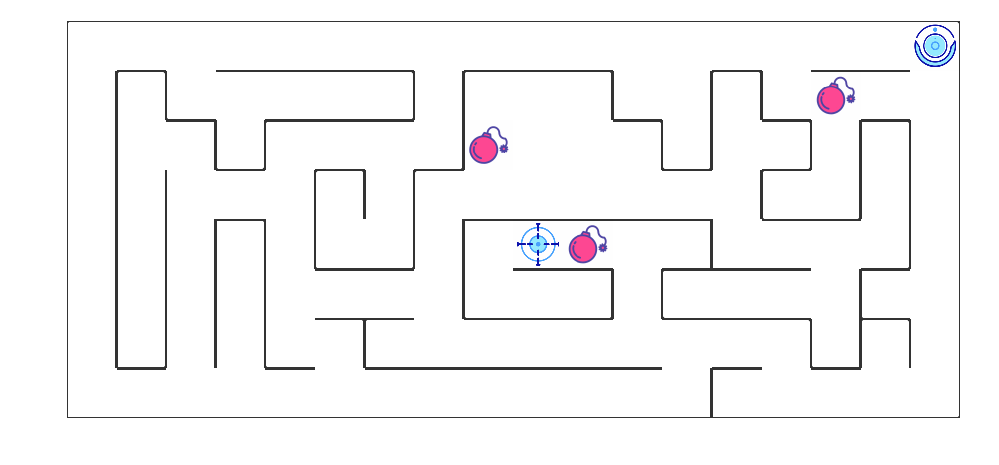

Maze of size (8, 18)

In [2]:
from Maze import Maze
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## todo: 创建迷宫并展示
maze=Maze(maze_size=(8,18),trap_number=3)
maze

---

你可能已经注意到，在迷宫中我们已经默认放置了一个机器人。实际上，我们为迷宫配置了相应的 API，来帮助机器人的移动与感知。其中你随后会使用的两个 API 为 `maze.sense_robot()` 及 `maze.move_robot()`。

1. `maze.sense_robot()` 为一个无参数的函数，输出机器人在迷宫中目前的位置。
2. `maze.move_robot(direction)` 对输入的移动方向，移动机器人，并返回对应动作的奖励值。

---

**问题 5**：随机移动机器人，并记录下获得的奖励，展示出机器人最后的位置。

In [3]:
rewards = []

## 循环、随机移动机器人10次，记录下奖励
for i in range(10):
    m_pos = maze.sense_robot()
    m_reward = maze.move_robot(actions[random.randint(0,3)])
    #print('pos:',m_pos)
    #print('reward:',m_reward)
    
    

## 输出机器人最后的位置
print('robot_position:',m_pos)

## 打印迷宫，观察机器人位置

robot_position: (0, 14)


## 2.2. `Robot` 类实现

`Robot` 类是我们需要重点实现的部分。在这个类中，我们需要实现诸多功能，以使得我们成功实现一个强化学习智能体。总体来说，之前我们是人为地在环境中移动了机器人，但是现在通过实现 `Robot` 这个类，机器人将会自己移动。通过实现学习函数，`Robot` 类将会学习到如何选择最优的动作，并且更新强化学习中对应的参数。

首先 `Robot` 有多个输入，其中 `alpha=0.5, gamma=0.9, epsilon0=0.5` 表征强化学习相关的各个参数的默认值，这些在之前你已经了解到，`Maze` 应为机器人所在迷宫对象。

随后观察 `Robot.update` 函数，它指明了在每次执行动作时，`Robot` 需要执行的程序。按照这些程序，各个函数的功能也就明了了。

最后你需要实现 `Robot.py` 代码中的8段代码，他们都在代码中以 `#TODO` 进行标注，你能轻松地找到他们。

---

**问题 6**：实现 `Robot.py` 中的8段代码，并运行如下代码检查效果（记得将 `maze` 变量修改为你创建迷宫的变量名）。



create_Qtable_line (1, 14)
create_Qtable_line {}
state: (1, 14)
create_Qtable_line (1, 14)
create_Qtable_line {(1, 14): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action:random_choose
****************action ***************************** r
-30.0
next_state: (1, 15)
create_Qtable_line (1, 15)
create_Qtable_line {(1, 14): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(1, 14): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (1, 15): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (1, 15)
update_Qtable:action r
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': 0.0, 'r': -51.300000000000004, 'd': 0.0, 'l': 0.0}
('r', -30.0)


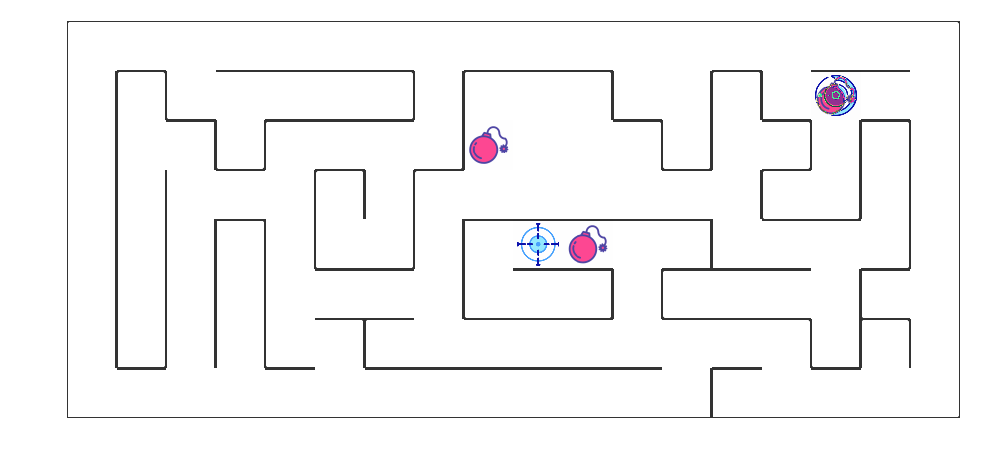

Maze of size (8, 18)

In [4]:
from Robot import Robot
robot = Robot(maze) # 记得将 maze 变量修改为你创建迷宫的变量名
robot.set_status(learning=True,testing=False)
print(robot.update())

maze

---

## 2.3 用 `Runner` 类训练 Robot

在实现了上述内容之后，我们就可以开始对我们 `Robot` 进行训练并调参了。我们为你准备了又一个非常棒的类 `Runner`，来实现整个训练过程及可视化。使用如下的代码，你可以成功对机器人进行训练。并且你会在当前文件夹中生成一个名为 `filename` 的视频，记录了整个训练的过程。通过观察该视频，你能够发现训练过程中的问题，并且优化你的代码及参数。

---

**问题 7**：尝试利用下列代码训练机器人，并进行调参。可选的参数包括：

- 训练参数
    - 训练次数 `epoch`
- 机器人参数：
    - `epsilon0` (epsilon 初值)
    - `epsilon`衰减（可以是线性、指数衰减，可以调整衰减的速度），你需要在 Robot.py 中调整
    - `alpha`
    - `gamma`
- 迷宫参数:
    - 迷宫大小
    - 迷宫中陷阱的数量

In [43]:
## 可选的参数：
epoch = 50
epsilon0 = 0.3
alpha = 0.6
gamma = 0.9

maze_size = (6,6)
trap_number = 1

In [44]:
from Runner import Runner

g = Maze(maze_size=maze_size,trap_number=trap_number)
r = Robot(g,alpha=alpha, epsilon0=epsilon0, gamma=gamma)
r.set_status(learning=True)

runner = Runner(r, g)
runner.run_training(epoch, display_direction=True)
runner.generate_movie(filename = "final1.mp4") # 你可以注释该行代码，加快运行速度，不过你就无法观察到视频了。

create_Qtable_line (0, 5)
create_Qtable_line {}
state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest u
****************action ***************************** u
-10.0
next_state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 5)
update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': 0.0, 'd': 0.0, 'l': 0.0}
state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
choose_action highest r
****************action ***************************** r
-10.0
next_state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 5)
update_Qtab

update_Qtable:next_state (1, 5)
update_Qtable:action r
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.312759, 'r': -17.1, 'd': 0.0, 'l': 0.0}
state: (1, 5)
create_Qtable_line (1, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': 0.0, 'l': 0.0}, (0, 4): {'u': 0.0, 'r': 0.0, 'd': -0.171, 'l': 0.0}, (1, 4): {'u': 0.0, 'r': -0.171, 'd': 0.0, 'l': 0.0}}
choose_action highest d
****************action ***************************** d
-0.1
next_state: (2, 5)
create_Qtable_line (2, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': 0.0, 'l': 0.0}, (0, 4): {'u': 0.0, 'r': 0.0, 'd': -0.171, 'l': 0.0}, (1, 4): {'u': 0.0, 'r': -0.171, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': 0.0, 'l': 0.0}, (0, 4): 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.171, 'l': 0.0}, (1, 4): {'u': -0.171, 'r': -0.171, 'd': 0.0, 'l': 0.0}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.171, 'l': 0.0}, (1, 4): {'u': -0.171, 'r': -0.171, 'd': 0.0, 'l': 0.0}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 4)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}
state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.171}, (1, 4): {'u': -0.171, 'r': -0.171, 'd': 0.0, 'l': 0.0}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (1, 4)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.171, 'r': -0.171, 'd': -17.1, 'l': 0.0}
state: (1, 4)
create_Qtable_line (1, 4)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.171}, (1, 4): {'u': -0.171, 'r': -0.171, 'd': -17.1, 'l': 0.0}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -0.295659, 'd': -17.1, 'l': 0.0}, (0, 2): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (0, 2)
update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': -0.295659, 'd': -17.1, 'l': -0.171}
state: (0, 2)
create_Qtable_line (0, 2)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -0.295659, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}}
choose_action:random_choose
****************action ***************************** r
-0.1
next_state: (0, 4)
create_Qtable_line (0, 4)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r'

create_Qtable_line (2, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (2, 4): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.171, 'r': -17.1, 'd': -0.17

create_Qtable_line (1, 4)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.171, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.171, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}}
choose_action highest r
****************action ***************************** r
-0.1
next_state: (1, 5)
create_Qtable_line (1, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.312759}, (0, 4): {'u': -17.1, '

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.32693490000000003, 'l': 0.0}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.18981, 'r': -17.1, 'd': -0.18810000000000002, 'l': -18.934659}, (5, 5): {'u': -0.18810000000000002, 'r': -17.1, 'd': 0.0, 'l': 0.0}}
next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34081839, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.18981, 'r': -17.1, 'd': -0.18810000000000002, 'l': -19.1305908}, (5, 5): {'u': -0.18810000000000002, 'r': -17.1, 'd': 0.0, 'l': 0.0}}
choose_action highest d
****************action ***************************** d
-0.1
next_state: (5, 5)
create_Qtable_line (5, 5)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': 

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34081839, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.18981, 'r': -17.1, 'd': -0.18981, 'l': -19.1305908}, (5, 5): {'u': -0.18810000000000002, 'r': -17.1, 'd': 0.0, 'l': -0.171}, (5, 4): {'u': 0.0, 'r': 0.0, 'd': 0.0, 'l': 0.0}}
update_Qtable:next_state (5, 4)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': 0.0, 'r': 0.0, 'd': -1

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

update_Qtable*********** {'u': -0.171, 'r': 0.0, 'd': 0.0, 'l': 0.0}
state: (1, 1)
create_Qtable_line (1, 1)
create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.325224900000

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

next_state_q {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -17.1, 

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

create_Qtable_line {(0, 5): {'u': -17.1, 'r': -17.1, 'd': -0.314469, 'l': -0.18810000000000002}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (1, 4): {'u': -0.312759, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.171}, (0, 2): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.810000000000002, 'r': -0.295659, 'd': -

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': 0.0}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'u': -18.8

update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': -0.171, 'd': -17.1, 'l': 0.0}
state: (0, 1)
create_Qtable_line (0, 1)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'

****************action ***************************** r
-0.1
next_state: (0, 1)
create_Qtable_line (0, 1)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.171, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3): {'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.171}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18810000000000002, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.1881000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.312759}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000002}, (5, 3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.314469, 'l': -0.32693490000000003}, (1, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.314469}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.18810000000000002}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.18981, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd': -18.934659, 'l': -0.18810000000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4304482110000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.295659, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004, 'd'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4304482110000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.3376908, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.32522490000000004,

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4304482110000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.3376908, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.325224900000000

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4304482110000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.325224

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.312759}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r': -0.325224

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.32522490000000004, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.314469, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.171}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'u': -17.1, 'r'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': 0.0, 'l': 0.0}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 'l': -0.314469}, (5, 4): {'

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.18810000000000002}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -

****************action ***************************** r
-10.0
next_state: (1, 3)
create_Qtable_line (1, 3)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.18810000000000002}, (4, 5): {'u': -0.31464000000000003, 'r

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.18810000000000002}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -

update_Qtable*********** {'u': -17.1, 'r': -19.24179784731, 'd': -0.41905790100000007, 'l': -17.1}
state: (2, 3)
create_Qtable_line (2, 3)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.18810000000000002}, (4, 5

update_Qtable:next_state (2, 4)
update_Qtable:action r
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.42689895210000006, 'r': -0.3376908, 'd': -17.1, 'l': -17.1}
state: (2, 4)
create_Qtable_line (2, 4)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.18810000000000002}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.4359865932}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, '

next_state: (2, 3)
create_Qtable_line (2, 3)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.4359865932}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u'

****************action ***************************** r
-0.1
next_state: (2, 4)
create_Qtable_line (2, 4)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.4359865932}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.295659, 'd': -51.300000000000004, 'l': -0.4359865932}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.934659, 'd': -17.1, '

update_Qtable*********** {'u': -17.1, 'r': -0.3376908, 'd': -51.300000000000004, 'l': -0.4359865932}
state: (2, 5)
create_Qtable_line (2, 5)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.312759, 'r': -17.1, 'd': -0.18810000000000002, 'l': -0.18810000000000002}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.171, 'r': -17.1, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.3376908, 'd': -51.300000000000004, 'l': -0.4359865932}, (4, 5): {

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.3271059, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.44073610110000006, 'r': -17.1, 'd': -0.43953585210000007, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.4315238010000001, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {

update_Qtable:next_state (2, 5)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}
state: (2, 5)
create_Qtable_line (2, 5)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.44073610110000006, 'r': -17.1, 'd': -0.43953585210000007, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.4315238010000001, 'r': -19.04708895

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.44073610110000006, 'r': -17.1, 'd': -0.43953585210000007, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.4315238010000001, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.44073610110000006, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.4315238010000001, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.44073610110000006, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u

update_Qtable:action u
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}
state: (1, 5)
create_Qtable_line (1, 5)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1},

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.4393648521000001}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.3

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.46235966841000015}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.33940080000000006, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.46235966841000015}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.33957180000000003}, (1, 4): {'u': -0.4524879222, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.3

update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.5004539846190001}
state: (0, 3)
create_Qtable_line (0, 3)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.46235966841000015}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.5004539846190001}, (1, 4): {'u': -0.4524879222, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.46235966841000015}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.5004539846190001}, (1, 4): {'u': -0.4524879222, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.40534541100000004}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.432941391}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.46235966841000015}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.4178113110000001, 'l': -0.5004539846190001}, (1, 4): {'u': -0.4524879222, 'r': -0.43277039100000003, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.4499947422000001}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.32710590000000006, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.328

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5004539846190001}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.4499947422000001}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.34208208, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149

<class 'float'>
update_Qtable*********** {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}
state: (0, 3)
create_Qtable_line (0, 3)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.4499947422000001}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.34208208, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.3

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.4499947422000001}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.34208208, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -1

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.34208208, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149

<class 'float'>
update_Qtable*********** {'u': -0.33893739, 'r': -17.1, 'd': 45.10983420000001, 'l': -18.948496149}
state: (2, 2)
create_Qtable_line (2, 2)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.3000000

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149

state: (0, 5)
create_Qtable_line (0, 5)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.4420461321000001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l':

update_Qtable:next_state (1, 5)
update_Qtable:action d
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -18.947124900000002, 'r': -17.1, 'd': -0.5364103545009001, 'l': -0.5188785848190001}
state: (1, 5)
create_Qtable_line (1, 5)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.5364103545009001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.5364103545009001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.44061144210000003, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.5364103545009001, 'l': -0.5188785848190001}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149,

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.5364103545009001, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5241322261809, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.5185658258190001, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.465331062051, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.34345332900000003, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.31464000000000003, 'r': -17.1, 'd': -0.32710590000000006, 'l': -19.1305908}, (5, 5): {'u': -0.32818149,

update_Qtable:action l
<class 'float'>
<class 'float'>
update_Qtable*********** {'u': -18.9981, 'r': -0.34314057000000003, 'd': -17.1, 'l': -0.43953585210000007}
state: (5, 1)
create_Qtable_line (5, 1)
create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.93

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.93

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': -18.93

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.32818149, 'r': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.519444888939, '

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.1305908}, (5, 5): {'u': -0.519444888939, 'r': -1

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.432958491, 'l': -19.328685819939}, (5, 5): {'u': -0.5194448889

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': -0.3437168229, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.51944488

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.51944488

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.51944488

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.51944488

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.43027721100000005}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, '

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': -0.5276998079190001}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.5194448889

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444888939, 'r

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 32.67969744951, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.5194448889

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6009223455039512}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5626395668532691, 'l': -0.5470996621248}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.528270746139, 'l': -0.5490915655257}, (1, 4): {'u': -0.5810797470072512, 'r': -0.5354827803909001, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.5353705872909001, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.4509456732, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': -0.519444

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.55464855231537}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6204333619579047, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.565724914615197}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6204333619579047, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.565724914615197}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6204333619579047, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.565724914615197}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5):

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -17.1, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (5, 5): {'u':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': -0.46537731054000003}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.32868581

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.3286858199

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 35.982038876751005, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.3286858199

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.3286858199

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.328685819939}, (

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.3286858199

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6067334283359662, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5683707717259339, 'l': -0.6493171017807662}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6233839317280693, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.4679105830461, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.5354489978019, 'r': -19.0470889521, 'd': -0.4529319903900001, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.5193733439241001, 'r': -17.1, 'd': -0.4618436913, 'l': -19.3286858199

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.5479784792989201, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l': -19.3

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.5479784792989201, 'l': -0.5464297446588001}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l': -19.3286858

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.4432291460100001, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l': -19.328

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l': -19.328

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -17.1, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l': -19.328685819

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.209476311408917, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.54875702190717}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l':

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.5210006332590001}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.54870763049577

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.6015845468993312}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.54870763049577

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.6015845468993312}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.6015845468993312}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.54870763049577

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.6015845468993312}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.54870763049577

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.5479784792989201, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6228921836364553, 'r': -19.0470889521, 'd': -0.5529772499967, 'l': -17.1}, (2, 4): {'u': -17.1, 'r': -0.6147992260099128, 'd': -51.300000000000004, 'l': -0.6015845468993312}, (4, 5): {'u': -0.6132796537899952, 'r': -17.1, 'd': -0.5487076304957799, 'l

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.631956234009904, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6056851638365282}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.631956234009904, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6644

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.631956234009904, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6233727124180692, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.664

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.5689438922132003, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6289182631774861, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.664

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.6263055876310936, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.664

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

choose_action:random_choose {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 46.239430279634114, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6162016084857261}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': -0.5668325508451797}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 18.73606246167655}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': -0.6454567989502692, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 18.73606246167655}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 18.73606246167655}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 26.013368610097487}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 38.334760268582194}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 38.334760268582194}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.25160961258223, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 38.334760268582194}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.8839684636169, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 38.334760268582194}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.8839684636169, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': -0.6458410904147086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 20.666351962928722}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 38.334760268582194}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 49.8839684636169, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 14.830186471933565}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 29.84167543208929}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 14.830186471933565}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 29.84167543208929}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 14.830186471933565}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 29.84167543208929}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 29.84167543208929}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 29.84167543208929}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.02710479307687}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 13.42304385466718, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.02710479307687}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.02710479307687}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681787502

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.07398799707537}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.29281702182392}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.29281702182392}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.00880414556431, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681787502

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.29281702182392}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.016319224418595, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.29281702182392}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.016319224418595, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 23.066600037186447}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.24564772917563}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.29281702182392}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.016319224418595, 'l': 16.985666948919963}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 25.642737198287676}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.427028381827206}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.46511290401793}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 24.519063779619756, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.46511290401793}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.46511290401793}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750288

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.468921356237}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': -19.118124899999998, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

create_Qtable_line {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.468921356237}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681787502

next_state_q {(0, 5): {'u': -18.947124900000002, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.0325774101808}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.468921356237}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32017841678355}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01799811062805, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681787502888794

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.102101409714848}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.102101409714848}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028887

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.102101409714848}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.102101409714848}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.102101409714848}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.472189076117495}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028887

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': -19.149260059383664, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.324743783879}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817875028887949

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32483611300219}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01832885406624, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32483611300219}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01833503755345, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32483611300219}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01833503755345, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750288879

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': -17.1, 'd': -0.6460156354218024, 'l': 26.111435977461138}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47295712605954}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32483611300219}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.01833503755345, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178750

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335874512566, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113183737484086}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11322698515817}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11322698515817}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312566722876}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11322698515817}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312955654274}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485183788733}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11322698515817}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312955654274}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485211615714}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11322698515817}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47312955654274}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485211615714}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335984044455, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.11323414523547}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313014833283}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313014833283}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313014833283}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.473130235220545}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 25.947973684991045, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.473130235220545}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.473130235220545}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215416634}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999756374, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999970574, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999970574, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999970574, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999970574, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 1.9577605103260873, 'd': -0.6460156354218024, 'l': 26.113235292658178}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024390931}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 10.38181221250943, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159239036}, (0, 2): {'u': -18.810000000000002, 'r': -0.4467424932, 'd': 50.018335999970574, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.1132354770757}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.1132354770757}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.1132354770757}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.1132354770757}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6141940215188663, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024847618}, (1, 4): {'u': -0.6293957259689605, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024847618}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.630317069150877, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215996879}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1,

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215999432}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1,

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215999432}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.018335999996495, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1323245793804215, 'd': -0.6460156354218024, 'l': 26.113235498846706}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024946487}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.32485215999432}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999965, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235501744562}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024958235}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159999175}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1,

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024958235}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159999175}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1,

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024958235}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159999175}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.324852159999175}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1,

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833599999998, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 1.8760525762239835, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502119984}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': -0.6138997310130562, 'd': -0.6912488863832588, 'l': 32.47313024959763}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.096709309974884, 'd': 10.38159757583521, 'l': 40.3248521599999}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249599976}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.324852160000006}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.324852160000006}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.324852160000006}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502175677}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.473130249600004}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 10.38159757583521, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 27.872798340654647}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6460156354218024, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': 

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176}, (1, 5): {'u': -0.5933236325430511, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.681

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.334976982223536, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.6817

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': -17.1, 'r': 18.804158707984296, 'd': -0.6912488863832588, 'l': 32.47313024960001}, (1, 4): {'u': 23.43897237854224, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11158288295587, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.630314922862368, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 4.862911951958411, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 29.181142975248893, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': -18.810000000000002, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.0592031471542525, 'r': 20.745964551884736, 'd': 16.84688597531897, 'l': 32.47313024960001}, (1, 4): {'u': 25.845809189812627, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.11307024025399, 'd': 13.65984871692625, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.4402103768565, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.65984893153234, 'r': 26.113233849556785, 'd': 13.662802096332639, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 31.706866703585977}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113233849556785, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663097434273277, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.46983826232566, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.472801050872576, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.662802117793248, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.472801050872576, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.472801050872576, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.472801050872576, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 17.482366944000013, 'r': 32.472801050872576, 'd': 50.01833600000001, 'l': 32.36588085948666}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.3552834969053, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd':

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.08649287093967, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.278832266673836, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

 {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd': -0.68178

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.745964551884736, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.124153938708005, 'r': 2.1497811387098293, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235336914084, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.111603638400013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663097436419338, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235500523388, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235502010742, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235502010742, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235502010742, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235502010742, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.113235502010742, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.47309732972727, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd'

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473126957612735, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473126957612735, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473126957612735, 'd': 50.01833600000001, 'l': 32.45934300703748}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 'd

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.94014513627478, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663126968067342, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473126957612735, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 

create_Qtable_line {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -

next_state_q {(0, 5): {'u': 2.1489640749571084, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, 

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550215948, 'd': 13.663129921446748, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

next_state_q {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -17.1, '

create_Qtable_line {(0, 5): {'u': 2.151445088582019, 'r': 2.151526794957291, 'd': -0.6681344916660644, 'l': 26.113235502176003}, (1, 5): {'u': 18.806216317832, 'r': -17.1, 'd': -0.6863758030777075, 'l': -0.6903785964078392}, (0, 4): {'u': 7.300795178625795, 'r': 20.959563194713784, 'd': 20.881581652605544, 'l': 32.47313024960001}, (1, 4): {'u': 26.110561239052373, 'r': -0.6476806857610127, 'd': -17.1, 'l': -17.1}, (2, 5): {'u': -0.6480973686652298, 'r': -19.420423942549807, 'd': -0.6904685997008159, 'l': -0.6922646109768728}, (0, 3): {'u': 13.663126968281947, 'r': 26.11323550217584, 'd': 13.663130216784689, 'l': 40.32485216000001}, (0, 2): {'u': 21.474527307840013, 'r': 32.473129920401284, 'd': 50.01833600000001, 'l': 32.471445294988634}, (3, 5): {'u': -0.6748337028004746, 'r': -19.0470889521, 'd': -0.7179880620251547, 'l': -17.1}, (2, 4): {'u': -19.473044149230187, 'r': -0.6886343307537629, 'd': -51.300000000000004, 'l': -0.6376411039106116}, (4, 5): {'u': -0.6864163672499755, 'r': -1

Generate Movies: 100%|██████████| 1007/1007 [00:22<00:00, 43.91it/s]


---

使用 `runner.plot_results()` 函数，能够打印机器人在训练过程中的一些参数信息。

- Success Times 代表机器人在训练过程中成功的累计次数，这应当是一个累积递增的图像。
- Accumulated Rewards 代表机器人在每次训练 epoch 中，获得的累积奖励的值，这应当是一个逐步递增的图像。
- Running Times per Epoch 代表在每次训练 epoch 中，小车训练的次数（到达终点就会停止该 epoch 转入下次训练），这应当是一个逐步递减的图像。

---

**问题 8**：使用 `runner.plot_results()` 输出训练结果，根据该结果对你的机器人进行分析。

- 指出你选用的参数如何，选用参数的原因。
- 建议你比较不同参数下机器人的训练的情况。
- 训练的结果是否满意，有何改进的计划。

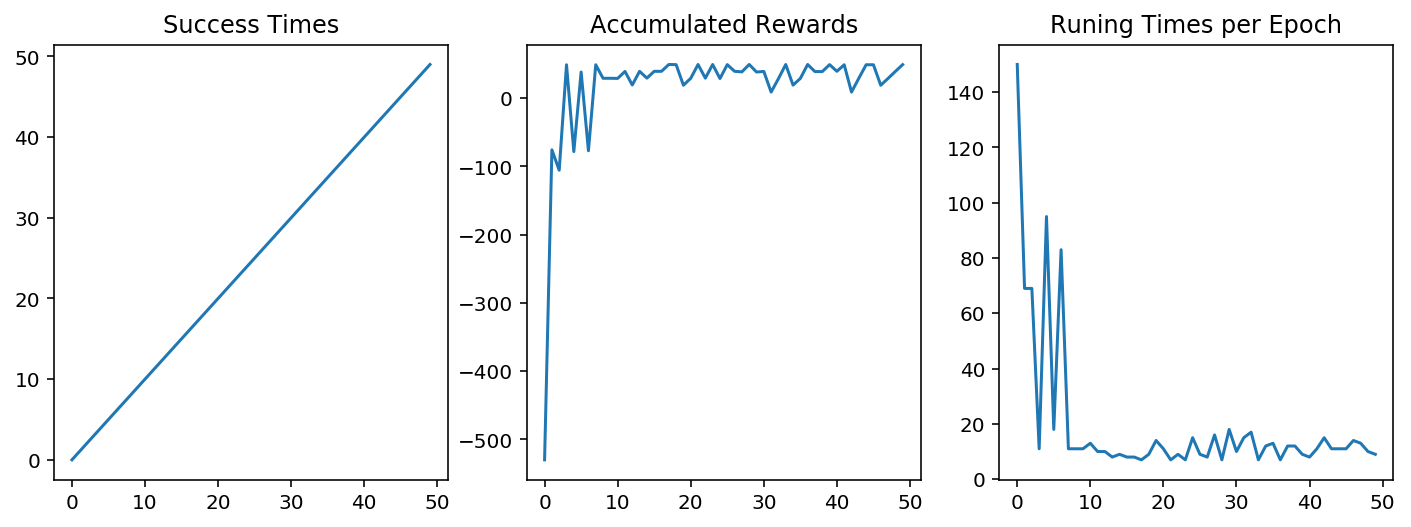

In [45]:
runner.plot_results()

(回答区)

（1）

epsilon0=0.3,设置较小的数，使得初始状态时候能随机获得更多的状态

alpha =0.6，alpha 值（0.1）太小时候，学习效果不好，过程收敛慢，alpha（0.9）太大时候，过于看重过去的回馈奖励，不利于学习新的环境

gamma = 0.9 gamma 的值接近于1 ，有利于学习反馈的效果，不然学习效果不好 收敛慢


（2）

A :调参过程中 对比了 alpha=0.1 和 alpha=0.9 及0.6 的情况，alpha=0.1 时候 学习效率慢，波动相对来说有点大， 而alpha=0.9时候，学习速度很快，epoch 没几次就学会了，但这种情况是 过于看重过去的回馈奖励，不利于学习新的环境，因此取了中间的值。

B:此外 还对比了 gamma=0.9 和gamma=0.1 的情况，gamma=0.9 时候 情况比较正常，趋于稳定，gamma=0.1 时候 波动特别大，学习效果特别不好

(3) 

对于学习效果基本满意，现在学习算法中 epsilon 的衰减是线性的，以后可以尝试一下 非线性衰减的情况



---

**问题 9：** 请将如下的文件打包，提交文件给审阅者。

- `robot.py`
- `robot_maze.ipynb`
- 由 `robot_maze.ipynb` 导出的 `robot_maze.html`